In [17]:
print("Hello World")

Hello World


In [1]:
import torch

data = [[1, 2, 3], [4, 5, 6]]  # Example list
t = torch.tensor(data)  # Convert list to tensor
t_transposed = torch.t(t)  # Now transpose it
print(t_transposed)
print("Hello World!")

tensor([[1, 4],
        [2, 5],
        [3, 6]])
Hello World!


Found 4 classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Class 'Cyst': 3284 images
Class 'Normal': 5002 images
Class 'Stone': 1360 images
Class 'Tumor': 2283 images


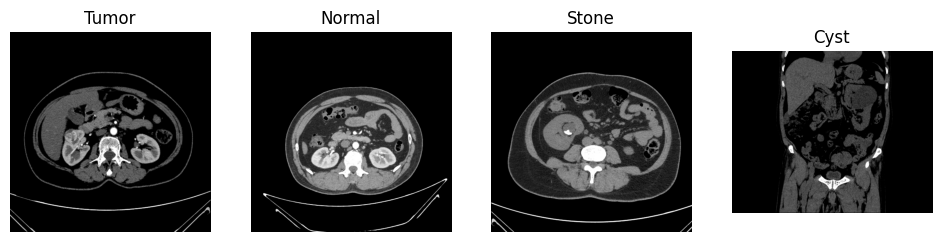

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the dataset path
dataset_path = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
class_labels = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print(f"Found {len(class_labels)} classes: {class_labels}")
image_files = {label: [] for label in class_labels}
for label in class_labels:
    class_dir = os.path.join(dataset_path, label)
    image_files[label] = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Print number of images per class
for label, files in image_files.items():
    print(f"Class '{label}': {len(files)} images")

# Function to display sample images
def show_sample_images(image_files, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(random.sample(class_labels, min(num_samples, len(class_labels)))):
        if image_files[label]:
            img_path = random.choice(image_files[label])
            img = Image.open(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis("off")
    plt.show()

# Display sample images
show_sample_images(image_files)

        Image Count
Normal         5002
Cyst           3284
Tumor          2283
Stone          1360


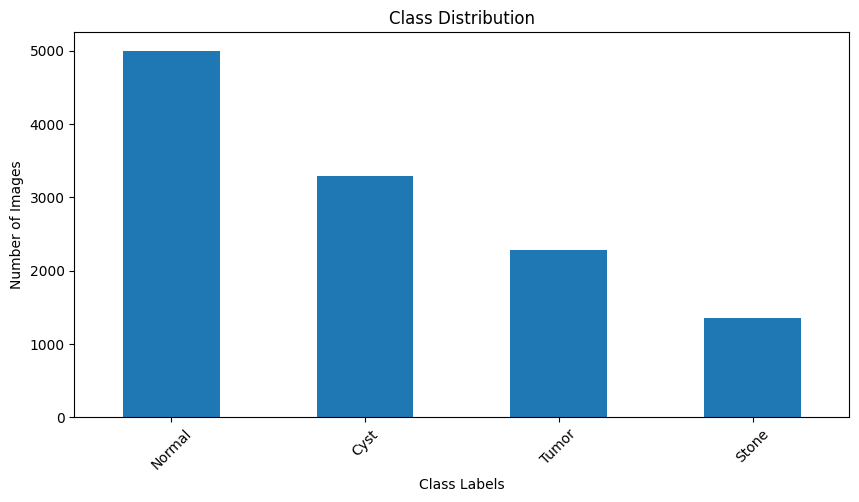

In [3]:
import pandas as pd

# Count the number of images per class
class_counts = {label: len(files) for label, files in image_files.items()}

# Convert to a DataFrame for easy visualization
df_classes = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
df_classes.sort_values(by='Image Count', ascending=False, inplace=True)

print(df_classes)

# Plot class distribution
df_classes.plot(kind='bar', figsize=(10, 5), title="Class Distribution", legend=False)
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

[[705 569]
 [512 512]
 [512 512]
 ...
 [512 512]
 [512 512]
 [512 512]]
[705 512 512 ... 512 512 512]
[569 512 512 ... 512 512 512]


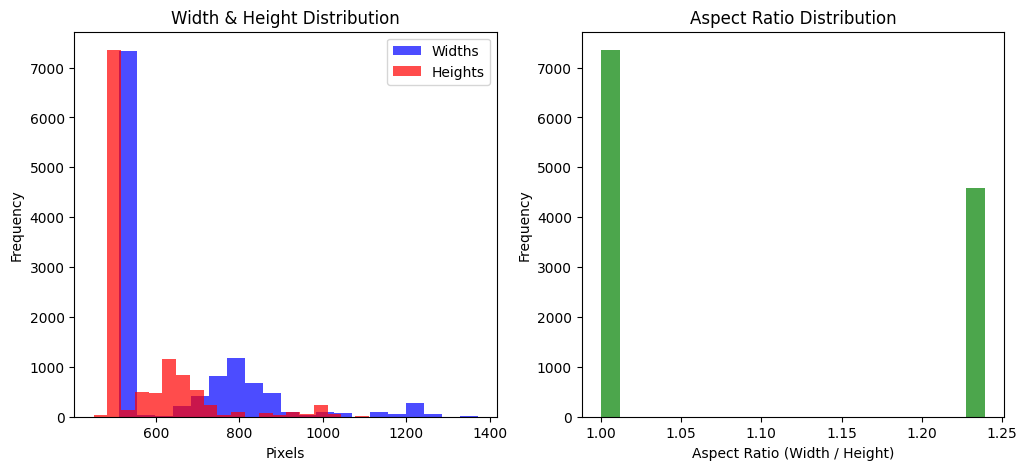

In [4]:
import numpy as np

image_shapes = []

# Collect image sizes
for label, files in image_files.items():
    for img_path in files:
        img = Image.open(img_path)
        image_shapes.append(img.size)

# Convert to NumPy array for analysis
image_shapes = np.array(image_shapes)
widths, heights = image_shapes[:, 0], image_shapes[:, 1]
print(image_shapes)
print(widths)
print(heights)
# Plot distributions
plt.figure(figsize=(12, 5))

# Width & Height distribution
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='blue', alpha=0.7, label="Widths")
plt.hist(heights, bins=20, color='red', alpha=0.7, label="Heights")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.title("Width & Height Distribution")
plt.legend()

# Aspect Ratio Distribution
aspect_ratios = widths / heights
plt.subplot(1, 2, 2)
plt.hist(aspect_ratios, bins=20, color='green', alpha=0.7)
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Aspect Ratio Distribution")

plt.show()

In [5]:
import hashlib

def get_image_hash(image_path):
    """Generate hash for an image file to detect duplicates."""
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Store hashes and detect duplicates
hashes = {}
duplicates = []

for label, files in image_files.items():
    for img_path in files:
        img_hash = get_image_hash(img_path)
        if img_hash in hashes:
            duplicates.append(img_path)
        else:
            hashes[img_hash] = img_path

print(f"Found {len(duplicates)} duplicate images.")
if duplicates:
    print("Sample duplicates:", duplicates[:5])

Found 0 duplicate images.


In [6]:
def get_image_hash(image_path):
    """Generate a unique hash for an image file to detect duplicates."""
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Dictionary to store image hashes
hashes = {}
duplicates = []

for label, files in image_files.items():
    for img_path in files:
        img_hash = get_image_hash(img_path)

        if img_hash in hashes:
            duplicates.append(img_path)
        else:
            hashes[img_hash] = img_path

# Print duplicate images found
print(f"Found {len(duplicates)} duplicate images.")

# Optional: Preview duplicates before deletion
if duplicates:
    print("Sample duplicates:", duplicates[:5])

# Delete duplicates
for dup in duplicates:
    os.remove(dup)

print(f"Deleted {len(duplicates)} duplicate images.")

Found 0 duplicate images.
Deleted 0 duplicate images.


Resizing and padding complete. Resized images saved in: C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized/Tumor


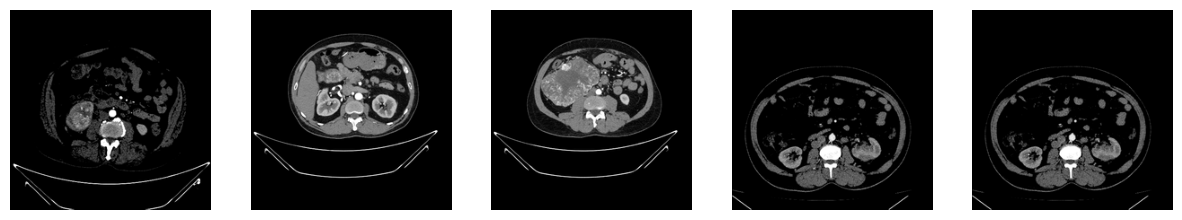

In [7]:
#NEW CODE - Tumor
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision import transforms

# Define paths
input_folder = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"
output_folder = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized/Tumor"
os.makedirs(output_folder, exist_ok=True)

# Define transformation (resize with padding)
def process_image(image_path, target_size=(224, 224)):
    try:
        img = Image.open(image_path).convert("RGB")  # Ensure 3-channel image

        # Get original dimensions
        w, h = img.size
        aspect_ratio = w / h

        # Calculate new size maintaining aspect ratio
        if w > h:
            new_w = target_size[0]
            new_h = int(target_size[0] / aspect_ratio)
        else:
            new_h = target_size[1]
            new_w = int(target_size[1] * aspect_ratio)

        img = img.resize((new_w, new_h), Image.LANCZOS)  # Resize with high-quality filter

        # Create new square image and paste resized image onto it (padding)
        new_img = Image.new("RGB", target_size, (0, 0, 0))  # Black background
        paste_x = (target_size[0] - new_w) // 2
        paste_y = (target_size[1] - new_h) // 2
        new_img.paste(img, (paste_x, paste_y))

        return new_img

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Process and save images
image_paths = [os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith(("png", "jpg", "jpeg"))]

for image_path in image_paths:
    processed_img = process_image(image_path)
    if processed_img:
        processed_img.save(os.path.join(output_folder, os.path.basename(image_path)))

print(f"Resizing and padding complete. Resized images saved in: {output_folder}")

# Display sample images
sample_images = image_paths[:5]  # Show first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_path in enumerate(sample_images):
    img = process_image(img_path)
    if img:
        axes[i].imshow(img)
        axes[i].axis("off")
plt.show()


Resizing and padding complete. Resized images saved in: C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized/Cyst


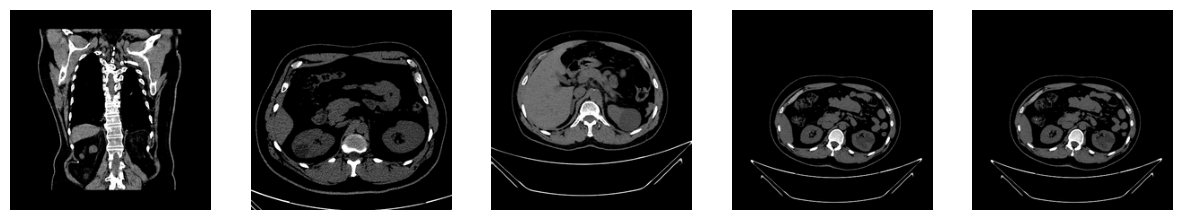

In [8]:
#NEW CODE - Cyst
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision import transforms

# Define paths
input_folder = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"
output_folder = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized/Cyst"
os.makedirs(output_folder, exist_ok=True)

# Define transformation (resize with padding)
def process_image(image_path, target_size=(224, 224)):
    try:
        img = Image.open(image_path).convert("RGB")  # Ensure 3-channel image

        # Get original dimensions
        w, h = img.size
        aspect_ratio = w / h

        # Calculate new size maintaining aspect ratio
        if w > h:
            new_w = target_size[0]
            new_h = int(target_size[0] / aspect_ratio)
        else:
            new_h = target_size[1]
            new_w = int(target_size[1] * aspect_ratio)

        img = img.resize((new_w, new_h), Image.LANCZOS)  # Resize with high-quality filter

        # Create new square image and paste resized image onto it (padding)
        new_img = Image.new("RGB", target_size, (0, 0, 0))  # Black background
        paste_x = (target_size[0] - new_w) // 2
        paste_y = (target_size[1] - new_h) // 2
        new_img.paste(img, (paste_x, paste_y))

        return new_img

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Process and save images
image_paths = [os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith(("png", "jpg", "jpeg"))]

for image_path in image_paths:
    processed_img = process_image(image_path)
    if processed_img:
        processed_img.save(os.path.join(output_folder, os.path.basename(image_path)))

print(f"Resizing and padding complete. Resized images saved in: {output_folder}")

# Display sample images
sample_images = image_paths[:5]  # Show first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_path in enumerate(sample_images):
    img = process_image(img_path)
    if img:
        axes[i].imshow(img)
        axes[i].axis("off")
plt.show()



Resizing and padding complete. Resized images saved in: C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized/Stone


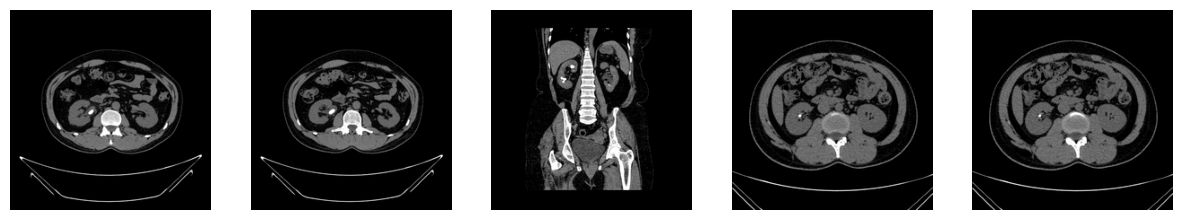

In [9]:
#NEW CODE - Stone
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision import transforms

# Define paths
input_folder = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"
output_folder = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized/Stone"
os.makedirs(output_folder, exist_ok=True)

# Define transformation (resize with padding)
def process_image(image_path, target_size=(224, 224)):
    try:
        img = Image.open(image_path).convert("RGB")  # Ensure 3-channel image

        # Get original dimensions
        w, h = img.size
        aspect_ratio = w / h

        # Calculate new size maintaining aspect ratio
        if w > h:
            new_w = target_size[0]
            new_h = int(target_size[0] / aspect_ratio)
        else:
            new_h = target_size[1]
            new_w = int(target_size[1] * aspect_ratio)

        img = img.resize((new_w, new_h), Image.LANCZOS)  # Resize with high-quality filter

        # Create new square image and paste resized image onto it (padding)
        new_img = Image.new("RGB", target_size, (0, 0, 0))  # Black background
        paste_x = (target_size[0] - new_w) // 2
        paste_y = (target_size[1] - new_h) // 2
        new_img.paste(img, (paste_x, paste_y))

        return new_img

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Process and save images
image_paths = [os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith(("png", "jpg", "jpeg"))]

for image_path in image_paths:
    processed_img = process_image(image_path)
    if processed_img:
        processed_img.save(os.path.join(output_folder, os.path.basename(image_path)))

print(f"Resizing and padding complete. Resized images saved in: {output_folder}")

# Display sample images
sample_images = image_paths[:5]  # Show first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_path in enumerate(sample_images):
    img = process_image(img_path)
    if img:
        axes[i].imshow(img)
        axes[i].axis("off")
plt.show()


Resizing and padding complete. Resized images saved in: C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized/Normal


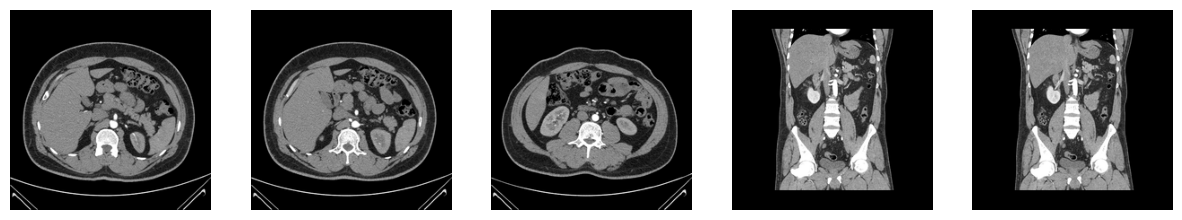

In [10]:
#NEW CODE Normal
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision import transforms

# Define paths
input_folder = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"
output_folder = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized/Normal"
os.makedirs(output_folder, exist_ok=True)

# Define transformation (resize with padding)
def process_image(image_path, target_size=(224, 224)):
    try:
        img = Image.open(image_path).convert("RGB")  # Ensure 3-channel image

        # Get original dimensions
        w, h = img.size
        aspect_ratio = w / h

        # Calculate new size maintaining aspect ratio
        if w > h:
            new_w = target_size[0]
            new_h = int(target_size[0] / aspect_ratio)
        else:
            new_h = target_size[1]
            new_w = int(target_size[1] * aspect_ratio)

        img = img.resize((new_w, new_h), Image.LANCZOS)  # Resize with high-quality filter

        # Create new square image and paste resized image onto it (padding)
        new_img = Image.new("RGB", target_size, (0, 0, 0))  # Black background
        paste_x = (target_size[0] - new_w) // 2
        paste_y = (target_size[1] - new_h) // 2
        new_img.paste(img, (paste_x, paste_y))

        return new_img

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Process and save images
image_paths = [os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith(("png", "jpg", "jpeg"))]

for image_path in image_paths:
    processed_img = process_image(image_path)
    if processed_img:
        processed_img.save(os.path.join(output_folder, os.path.basename(image_path)))

print(f"Resizing and padding complete. Resized images saved in: {output_folder}")

# Display sample images
sample_images = image_paths[:5]  # Show first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_path in enumerate(sample_images):
    img = process_image(img_path)
    if img:
        axes[i].imshow(img)
        axes[i].axis("off")
plt.show()


Found 4 classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Class 'Cyst': 3284 images
Class 'Normal': 5002 images
Class 'Stone': 1360 images
Class 'Tumor': 2283 images


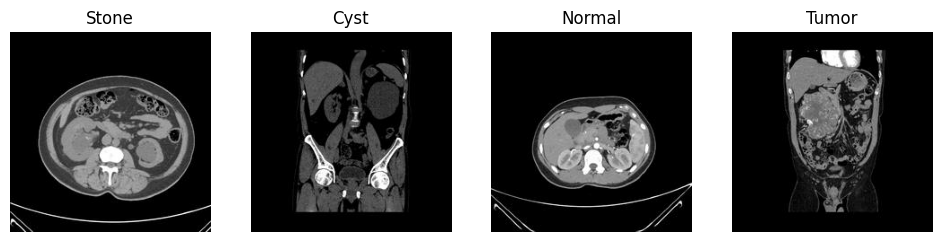

In [11]:
# Define the dataset path
dataset_path = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized"

# Get class labels (folder names)
class_labels = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

# Print basic info
print(f"Found {len(class_labels)} classes: {class_labels}")

# Dictionary to store image file paths
image_files = {label: [] for label in class_labels}

# Read images from each class
for label in class_labels:
    class_dir = os.path.join(dataset_path, label)
    image_files[label] = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Print number of images per class
for label, files in image_files.items():
    print(f"Class '{label}': {len(files)} images")

# Function to display sample images
def show_sample_images(image_files, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(random.sample(class_labels, min(num_samples, len(class_labels)))):
        if image_files[label]:
            img_path = random.choice(image_files[label])
            img = Image.open(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis("off")
    plt.show()

# Display sample images
show_sample_images(image_files)

        Image Count
Normal         5002
Cyst           3284
Tumor          2283
Stone          1360


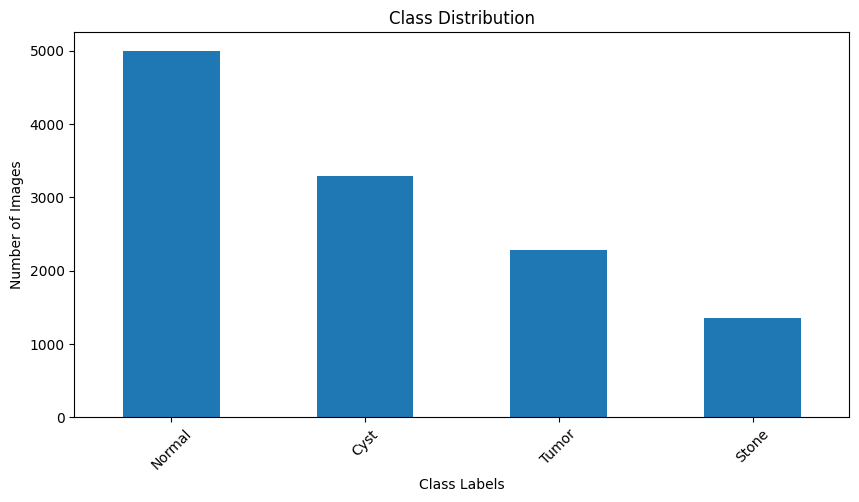

In [12]:
# Count the number of images per class
class_counts = {label: len(files) for label, files in image_files.items()}

# Convert to a DataFrame for easy visualization
df_classes = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
df_classes.sort_values(by='Image Count', ascending=False, inplace=True)

print(df_classes)

# Plot class distribution
df_classes.plot(kind='bar', figsize=(10, 5), title="Class Distribution", legend=False)
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

[[224 224]
 [224 224]
 [224 224]
 ...
 [224 224]
 [224 224]
 [224 224]]
[224 224 224 ... 224 224 224]
[224 224 224 ... 224 224 224]


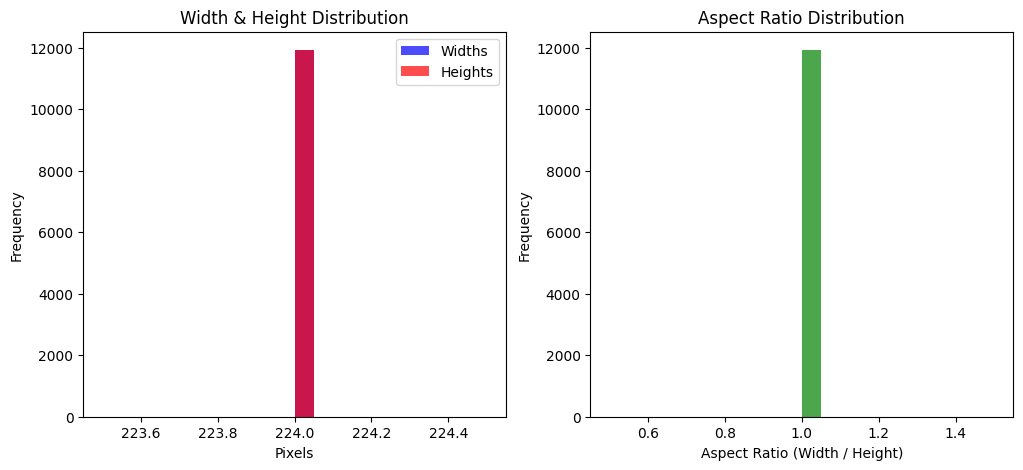

In [13]:
image_shapes = []

# Collect image sizes
for label, files in image_files.items():
    for img_path in files:
        img = Image.open(img_path)
        image_shapes.append(img.size)

# Convert to NumPy array for analysis
image_shapes = np.array(image_shapes)
widths, heights = image_shapes[:, 0], image_shapes[:, 1]
print(image_shapes)
print(widths)
print(heights)
# Plot distributions
plt.figure(figsize=(12, 5))

# Width & Height distribution
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='blue', alpha=0.7, label="Widths")
plt.hist(heights, bins=20, color='red', alpha=0.7, label="Heights")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.title("Width & Height Distribution")
plt.legend()

# Aspect Ratio Distribution
aspect_ratios = widths / heights
plt.subplot(1, 2, 2)
plt.hist(aspect_ratios, bins=20, color='green', alpha=0.7)
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Aspect Ratio Distribution")

plt.show()

In [14]:
import os
import random
from glob import glob
from PIL import Image
import torchvision.transforms as transforms

# Define dataset directory
dataset_path = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized"

# Get all class folders
class_folders = ["Normal", "Tumor", "Cyst", "Stone"]

# Count images in each class
image_counts = {cls: len(glob(os.path.join(dataset_path, cls, "*"))) for cls in class_folders}
max_images = max(image_counts.values())  # The target number for all classes

# Define augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

# Function to apply augmentation and save images
def augment_and_save(image_path, save_dir, class_name, start_index, num_augmentations):
    """Applies augmentation to an image and saves synthetic versions."""
    img = Image.open(image_path).convert("RGB")

    for i in range(num_augmentations):
        aug_img = augmentation_transforms(img)
        save_path = os.path.join(save_dir, f"aug_{class_name}_{start_index + i}.jpg")
        aug_img.save(save_path)

# Perform augmentation for underrepresented classes
for class_name in class_folders:
    class_path = os.path.join(dataset_path, class_name)
    image_paths = glob(os.path.join(class_path, "*"))

    num_images = image_counts[class_name]
    if num_images < max_images:
        images_needed = max_images - num_images
        print(f"Generating {images_needed} images for {class_name}...")

        start_index = num_images  # Ensure images are named uniquely

        while images_needed > 0:
            img_path = random.choice(image_paths)  # Randomly pick an image
            num_to_generate = min(5, images_needed)  # Generate up to 5 per image
            augment_and_save(img_path, class_path, class_name, start_index, num_to_generate)

            start_index += num_to_generate  # Increment properly
            images_needed -= num_to_generate  # Reduce the remaining count

print("Augmentation complete. Synthetic images saved in respective class folders.")


Generating 2719 images for Tumor...
Generating 1718 images for Cyst...
Generating 3642 images for Stone...
Augmentation complete. Synthetic images saved in respective class folders.


Found 4 classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Class 'Cyst': 5002 images
Class 'Normal': 5002 images
Class 'Stone': 5002 images
Class 'Tumor': 5002 images


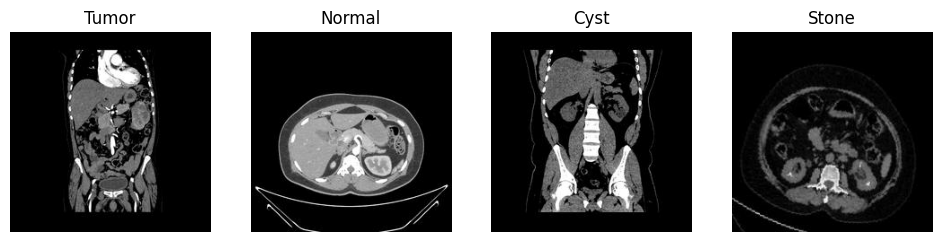

In [15]:
# Define the dataset path
dataset_path = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized"
class_labels = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print(f"Found {len(class_labels)} classes: {class_labels}")
image_files = {label: [] for label in class_labels}
for label in class_labels:
    class_dir = os.path.join(dataset_path, label)
    image_files[label] = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Print number of images per class
for label, files in image_files.items():
    print(f"Class '{label}': {len(files)} images")

# Function to display sample images
def show_sample_images(image_files, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(random.sample(class_labels, min(num_samples, len(class_labels)))):
        if image_files[label]:
            img_path = random.choice(image_files[label])
            img = Image.open(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis("off")
    plt.show()

# Display sample images
show_sample_images(image_files)

In [16]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is enabled
print(torch.version.cuda)  # Check CUDA version
print(torch.backends.cudnn.enabled)  # Ensure cuDNN is enabled

False
None
True


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import os

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Dataset Path
DATASET_PATH = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized"

# Define transformations for training & testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset from class folders
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Limit dataset to 3,000 images per class
class_counts = {class_idx: 0 for class_idx in range(len(dataset.classes))}
selected_indices = []

for idx, (_, class_idx) in enumerate(dataset.imgs):
    if class_counts[class_idx] < 1000:
        selected_indices.append(idx)
        class_counts[class_idx] += 1
    if all(count >= 3000 for count in class_counts.values()):
        break

subset_dataset = Subset(dataset, selected_indices)

# Split dataset into training (80%) and testing (20%)
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Load pre-trained EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=True)
model.to(device)  # Move model to device

# Modify the classifier for 4 classes
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(dataset.classes))
)

# Move classifier to device
model.to(device)

# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Function
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

# Train the Model
train(model, train_loader, criterion, optimizer, epochs=10)

# Testing Function
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model
test(model, test_loader)

# Save Model
torch.save(model.state_dict(), "efficientnet_model.pth")
print("Model saved successfully!")


Epoch [1/10], Loss: 0.4674, Accuracy: 86.03%
Epoch [2/10], Loss: 0.0439, Accuracy: 98.97%
Epoch [3/10], Loss: 0.0418, Accuracy: 98.69%
Epoch [4/10], Loss: 0.0210, Accuracy: 99.41%
Epoch [5/10], Loss: 0.0118, Accuracy: 99.66%
Epoch [6/10], Loss: 0.0068, Accuracy: 99.88%
Epoch [7/10], Loss: 0.0062, Accuracy: 99.81%
Epoch [8/10], Loss: 0.0120, Accuracy: 99.59%
Epoch [9/10], Loss: 0.0092, Accuracy: 99.78%
Epoch [10/10], Loss: 0.0135, Accuracy: 99.69%
Test Accuracy: 99.88%
Model saved successfully!


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import os

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Dataset Path
DATASET_PATH = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized"

# Define transformations for training & testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset from class folders
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Limit dataset to 3,000 images per class
class_counts = {class_idx: 0 for class_idx in range(len(dataset.classes))}
selected_indices = []

for idx, (_, class_idx) in enumerate(dataset.imgs):
    if class_counts[class_idx] < 1000:
        selected_indices.append(idx)
        class_counts[class_idx] += 1
    if all(count >= 3000 for count in class_counts.values()):
        break

subset_dataset = Subset(dataset, selected_indices)

# Split dataset into training (80%) and testing (20%)
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Load pre-trained GoogleNet model
model = models.googlenet(pretrained=True)
model.to(device)  # Move model to device

# Modify the classifier for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Move classifier to device
model.to(device)

# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Function
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

# Train the Model
train(model, train_loader, criterion, optimizer, epochs=10)

# Testing Function
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model
test(model, test_loader)

# Save Model
torch.save(model.state_dict(), "googlenet_model.pth")
print("GoogleNet Model saved successfully!")


Epoch [1/10], Loss: 0.3117, Accuracy: 92.16%
Epoch [2/10], Loss: 0.0221, Accuracy: 99.81%
Epoch [3/10], Loss: 0.0164, Accuracy: 99.59%
Epoch [4/10], Loss: 0.0185, Accuracy: 99.62%
Epoch [5/10], Loss: 0.0065, Accuracy: 99.97%
Epoch [6/10], Loss: 0.0082, Accuracy: 99.81%
Epoch [7/10], Loss: 0.0092, Accuracy: 99.75%
Epoch [8/10], Loss: 0.0104, Accuracy: 99.75%
Epoch [9/10], Loss: 0.0047, Accuracy: 99.94%
Epoch [10/10], Loss: 0.0053, Accuracy: 99.88%
Test Accuracy: 100.00%
GoogleNet Model saved successfully!


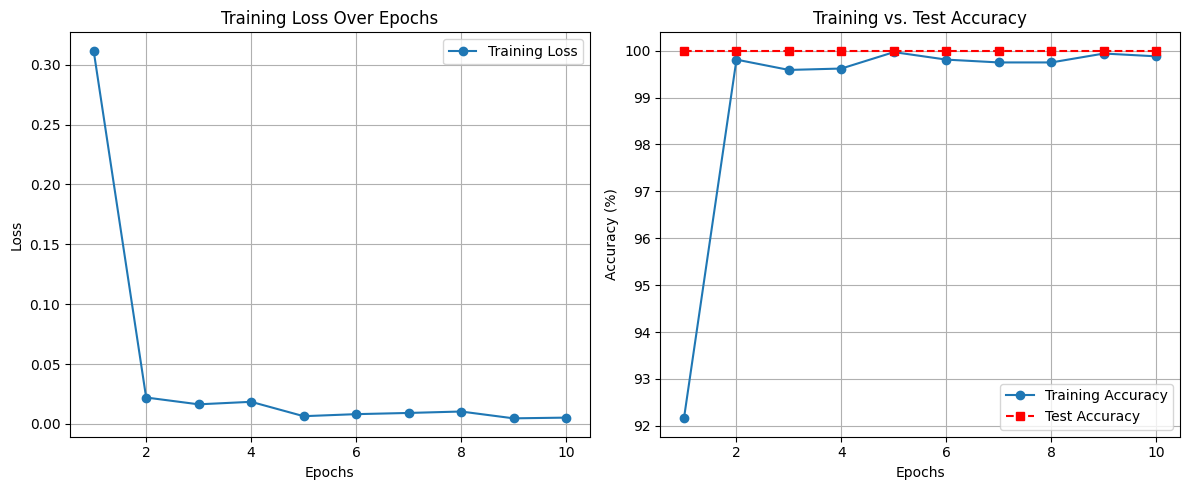

In [9]:
import matplotlib.pyplot as plt

# Data from the training output
train_losses = [0.3117, 0.0221, 0.0164, 0.0185, 0.0065, 0.0082, 0.0092, 0.0104, 0.0047, 0.0053]
train_accuracies = [92.16, 99.81, 99.59, 99.62, 99.97, 99.81, 99.75, 99.75, 99.94, 99.88]
test_accuracy = [100.00] * 10  # Test accuracy remains constant across epochs

epochs = range(1, 11)

# Plot Training Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()

# Plot Training Accuracy vs. Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker='o', linestyle='-')
plt.plot(epochs, test_accuracy, label="Test Accuracy", marker='s', linestyle='--', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs. Test Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Dataset Path
DATASET_PATH = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized"

# Define transformations for training & testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full dataset
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Split dataset into training (80%) and testing (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Load pre-trained GoogleNet model
model = models.googlenet(pretrained=True)
model.to(device)  # Move model to device

# Modify the classifier for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Move classifier to device
model.to(device)

# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Function
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

# Train the Model
train(model, train_loader, criterion, optimizer, epochs=10)

# Testing Function
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model
test(model, test_loader)

# Save Model
torch.save(model.state_dict(), "googlenet_model.pth")
print("GoogleNet Model saved successfully!")

Epoch [1/10], Loss: 0.1587, Accuracy: 94.93%
Epoch [2/10], Loss: 0.0212, Accuracy: 99.51%
Epoch [3/10], Loss: 0.0151, Accuracy: 99.61%
Epoch [4/10], Loss: 0.0113, Accuracy: 99.71%
Epoch [5/10], Loss: 0.0093, Accuracy: 99.77%
Epoch [6/10], Loss: 0.0075, Accuracy: 99.78%
Epoch [7/10], Loss: 0.0095, Accuracy: 99.72%


KeyboardInterrupt: 

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Dataset Path
DATASET_PATH = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full dataset
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Split dataset (80% Train, 20% Test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Modify classifier with added dropout and an extra FC layer
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(dataset.classes))
)

model.to(device)

# Define Loss Function & Optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Training Function
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

# Train the model
train(model, train_loader, criterion, optimizer, epochs=10)

# Testing Function
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model
test(model, test_loader)

# Save Model
torch.save(model.state_dict(), "efficientnet_model.pth")
print("EfficientNet Model saved successfully!")


c:\Users\vishv\OneDrive\Desktop\Data Science\New Example\myvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.2903, Accuracy: 88.70%
Epoch [2/10], Loss: 0.0438, Accuracy: 98.65%
Epoch [3/10], Loss: 0.0290, Accuracy: 99.01%
Epoch [4/10], Loss: 0.0244, Accuracy: 99.24%
Epoch [5/10], Loss: 0.0137, Accuracy: 99.64%
Epoch [6/10], Loss: 0.0158, Accuracy: 99.58%
Epoch [7/10], Loss: 0.0084, Accuracy: 99.75%
Epoch [8/10], Loss: 0.0185, Accuracy: 99.48%
Epoch [9/10], Loss: 0.0075, Accuracy: 99.82%
Epoch [10/10], Loss: 0.0144, Accuracy: 99.57%
Test Accuracy: 99.93%
EfficientNet Model saved successfully!


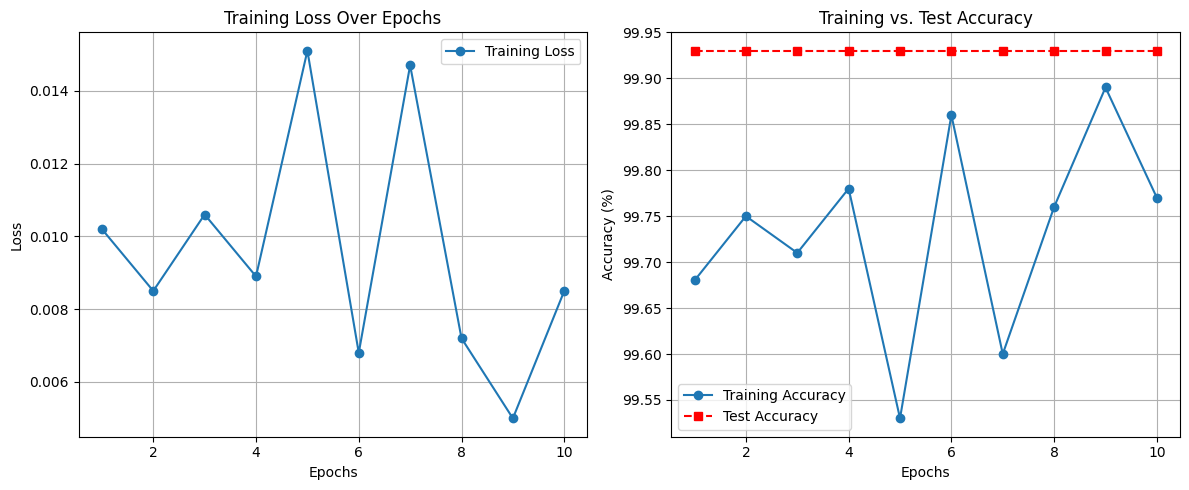

In [4]:
import matplotlib.pyplot as plt

# Data from the training output
train_losses = [0.0102, 0.0085, 0.0106, 0.0089, 0.0151, 0.0068, 0.0147, 0.0072, 0.0050, 0.0085]
train_accuracies = [99.68, 99.75, 99.71, 99.78, 99.53, 99.86, 99.60, 99.76, 99.89, 99.77]
test_accuracy = [99.93] * 10  # Test accuracy remains constant across epochs

epochs = range(1, 11)

# Plot Training Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()

# Plot Training Accuracy vs. Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker='o', linestyle='-')
plt.plot(epochs, test_accuracy, label="Test Accuracy", marker='s', linestyle='--', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs. Test Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
